In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *

In [2]:
img_data = Path('/scratch/bpho/datasets/mitomovies_001/')
model_path = Path('/scratch/bpho/models')

In [3]:
def get_src(size=128):
    hr_tifs = img_data/f'roi_hr_{size}'
    lr_tifs = img_data/f'roi_lr_up_{size}'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_resize_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=2)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [4]:
feat_loss =  FeatureLoss(vgg_m, blocks[2:5], [5,15,2]) # F.mse_loss

In [5]:
bs = 64
size = 128
data = get_data(bs, size, noise=0.03)
data

/scratch/bpho/datasets/mitomovies_001/roi_lr_up_128


ImageDataBunch;

Train: LabelList (3800 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128;

Valid: LabelList (1900 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/mitomovies_001/roi_lr_up_128;

Test: None

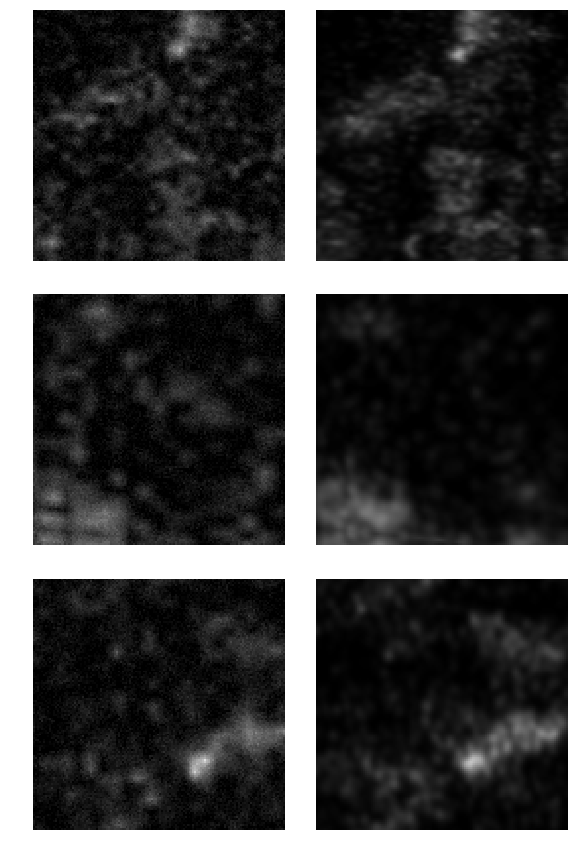

In [6]:
data.show_batch(3)

In [7]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11936

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [8]:
lr = 1e-3

In [9]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit('mitomovies_001_unet.0', slice(lr*10))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('mitomovies_001_unet.1', slice(1e-5,lr))

In [10]:
bs = 32
size = 256
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.1')

/scratch/bpho/datasets/mitomovies_001/roi_lr_up_256


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.982064,1.011327,0.058899,0.357324,12.312143,0.163755,0.225048,0.179388,0.031918,0.188552,0.207088,0.015578
2,0.987082,1.011083,0.058944,0.357196,12.308852,0.164010,0.224944,0.179499,0.031933,0.188145,0.206978,0.015573
3,0.985500,1.008582,0.058643,0.357999,12.331222,0.162906,0.224574,0.179239,0.031881,0.187975,0.206449,0.015558
4,0.983272,1.012992,0.059188,0.356609,12.290766,0.164765,0.225310,0.179662,0.031954,0.188209,0.207499,0.015593
5,0.985748,1.010454,0.058836,0.357458,12.316866,0.163618,0.224843,0.179385,0.031907,0.188292,0.206842,0.015568
6,0.984549,1.011439,0.059028,0.356842,12.302567,0.164294,0.225082,0.179474,0.031940,0.188016,0.207053,0.015580
7,0.985779,1.012110,0.059028,0.357139,12.302616,0.164107,0.225231,0.179540,0.031926,0.188300,0.207410,0.015596
8,0.986246,1.013871,0.059143,0.356909,12.294155,0.164444,0.225438,0.179638,0.031915,0.188886,0.207950,0.015599
9,0.984669,1.012196,0.059112,0.356826,12.296431,0.164491,0.225191,0.179575,0.031928,0.188100,0.207326,0.015585
10,0.983166,1.011019,0.058979,0.357187,12.306267,0.164052,0.224988,0.179563,0.031924,0.187836,0.207079,0.015578


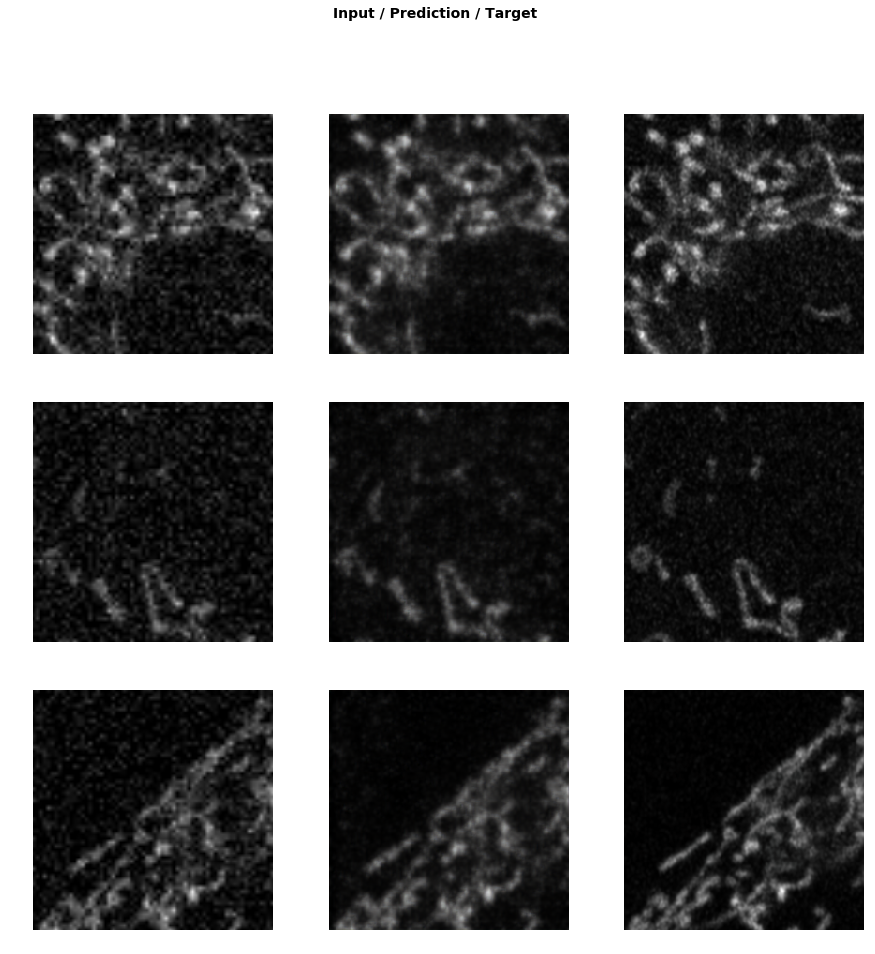

In [11]:
do_fit('mitomovies_001_unet.2', lr/10)

In [12]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.985770,1.009712,0.058873,0.357341,12.314144,0.163721,0.224778,0.179446,0.031908,0.187600,0.206696,0.015565
2,0.985067,1.012373,0.058993,0.357198,12.305237,0.164005,0.225260,0.179517,0.031927,0.188578,0.207491,0.015594
3,0.983517,1.012746,0.058976,0.357073,12.306430,0.164060,0.225244,0.179501,0.031939,0.188976,0.207440,0.015586
4,0.984490,1.013848,0.059106,0.356890,12.296797,0.164377,0.225460,0.179544,0.031934,0.189161,0.207774,0.015597
5,0.984129,1.013359,0.059128,0.356906,12.295173,0.164478,0.225391,0.179613,0.031935,0.188628,0.207715,0.015599
6,0.984676,1.011963,0.058956,0.357364,12.307985,0.163860,0.225155,0.179466,0.031899,0.188634,0.207364,0.015585
7,0.984676,1.013252,0.059136,0.356718,12.294544,0.164554,0.225390,0.179546,0.031958,0.188649,0.207557,0.015598
8,0.984389,1.011935,0.058992,0.357215,12.305323,0.164009,0.225148,0.179480,0.031909,0.188496,0.207311,0.015582
9,0.985723,1.011262,0.059059,0.357016,12.300323,0.164243,0.225116,0.179505,0.031923,0.187805,0.207086,0.015583
10,0.987724,1.008519,0.058678,0.357972,12.328675,0.163004,0.224564,0.179289,0.031881,0.187795,0.206430,0.015556


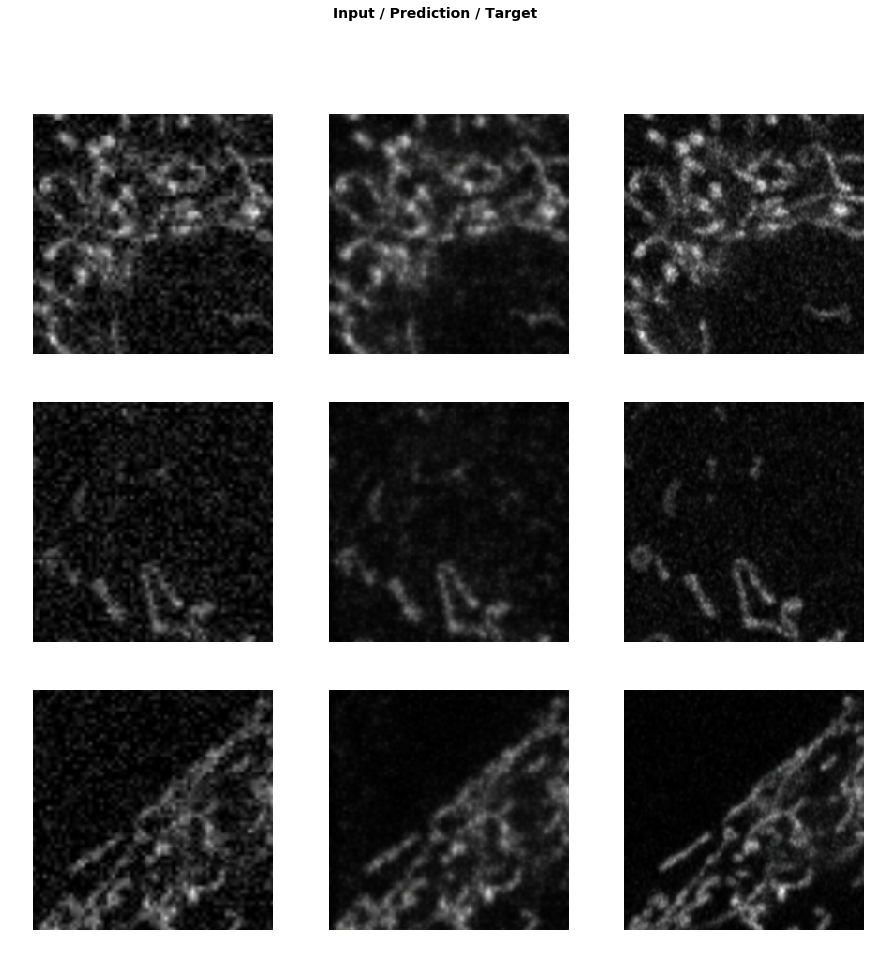

In [13]:
do_fit('mitomovies_001_unet.3', slice(1e-5,lr/10))

In [ ]:
bs = 4
size = 512
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.3')

/scratch/bpho/datasets/mitomovies_001/roi_lr_up_512


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.868815,0.888334,0.050657,0.311386,12.990392,0.160044,0.224191,0.163301,0.021363,0.175500,0.136398,0.007538
2,0.858500,0.866059,0.047875,0.314387,13.239556,0.152982,0.222337,0.162477,0.021244,0.166852,0.132708,0.007458
3,0.862419,0.863238,0.046942,0.315830,13.326866,0.150438,0.222163,0.162136,0.021205,0.166867,0.132968,0.007461
4,0.870747,0.872992,0.048674,0.313514,13.166553,0.155108,0.222787,0.162678,0.021274,0.169657,0.134019,0.007470
5,0.873641,0.873672,0.048719,0.313604,13.162324,0.155235,0.222865,0.162862,0.021309,0.169731,0.134195,0.007475
6,0.870219,0.885262,0.049906,0.311748,13.056239,0.158028,0.224174,0.163100,0.021335,0.174746,0.136336,0.007542
7,0.861375,0.876522,0.049044,0.312850,13.133110,0.155898,0.223395,0.162751,0.021305,0.170782,0.134892,0.007500
8,0.869286,0.871493,0.048426,0.313697,13.188755,0.154569,0.222657,0.162686,0.021281,0.169131,0.133710,0.007460
9,0.863623,0.868046,0.047740,0.314577,13.251842,0.152730,0.222471,0.162356,0.021252,0.168404,0.133378,0.007454
10,0.859268,0.868027,0.048325,0.314090,13.198017,0.154417,0.222214,0.162698,0.021286,0.166874,0.133089,0.007449


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



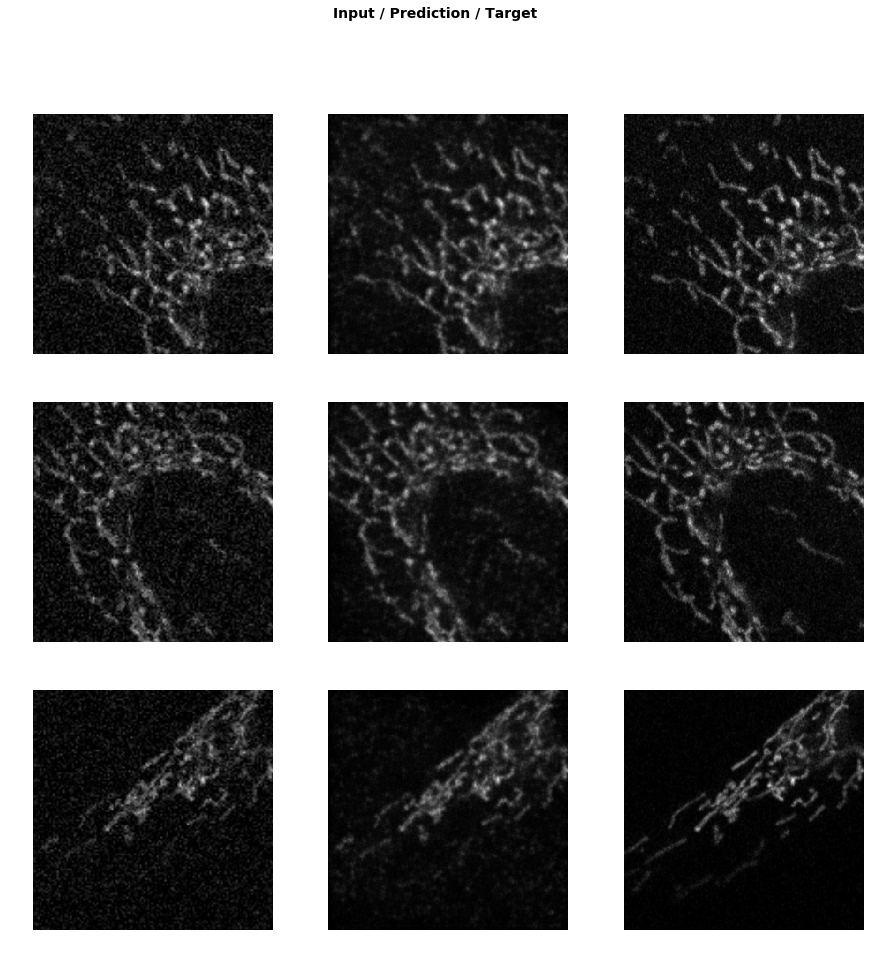

In [ ]:
do_fit('mitomovies_001_unet.4', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('mitomovies_001_unet.5', slice(1e-5,lr), cycle_len=50)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.866389,0.875398,0.049878,0.311990,13.058228,0.158360,0.222973,0.162929,0.021327,0.168491,0.133844,0.007474
2,0.856840,0.861148,0.046751,0.316117,13.344249,0.150333,0.221650,0.161987,0.021218,0.166272,0.132272,0.007415
3,0.871788,0.890310,0.050936,0.310701,12.966097,0.160636,0.224594,0.163474,0.021388,0.175839,0.136814,0.007565
4,0.872105,0.866998,0.048182,0.314210,13.211035,0.154049,0.222148,0.162390,0.021252,0.166853,0.132869,0.007437
5,0.857162,0.861574,0.047082,0.315744,13.313373,0.151092,0.221720,0.162136,0.021216,0.165645,0.132338,0.007428
6,0.869048,0.874456,0.048343,0.313979,13.196511,0.154370,0.222836,0.162874,0.021298,0.170975,0.134625,0.007478
7,0.869188,0.877165,0.048077,0.314216,13.221186,0.153369,0.223487,0.162723,0.021299,0.173269,0.135510,0.007507
8,0.866287,0.876259,0.050227,0.311276,13.026765,0.159459,0.222966,0.162884,0.021346,0.168476,0.133670,0.007457
9,0.866060,0.881557,0.049776,0.311966,13.067684,0.157764,0.223857,0.162936,0.021323,0.172518,0.135624,0.007534
10,0.868715,0.873164,0.048290,0.314077,13.201833,0.153901,0.223036,0.162620,0.021278,0.170333,0.134510,0.007486


In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.5')

In [ ]:
do_fit('mitomovies_001_unet.6', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('mitomovies_001_unet.7', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('mitomovies_001_unet.6')

In [ ]:
learn.unfreeze()
do_fit('mitomovies_001_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
print('whoohoo')

In [19]:
!ls /scratch/bpho/models

mitomovies_001_unet.0.pth    paired_001_unet.4.pth
mitomovies_001_unet.1.pth    paired_001_unet.5.pth
mitomovies_001_unet.2.pth    paired_001_unet.6.pth
mitomovies_001_unet.3.pth    paired_001_unet.7.pth
mitomovies_001_unet.4.pth    paired_001_unet.8.pkl
mitomovies_001_unet.5.pth    paired_001_unet.8.pth
movies_001.0.pth	     paired_001_unet_lr2hr.0.pth
movies_001.1.pth	     paired_001_unet_lr2hr.1.pth
movies_002_unet.0.pth	     paired_001_unet_lr2hr.2.pth
movies_002_unet.1.pth	     paired_001_unet_lr2hr.3.pkl
movies_002_unet.2.pth	     paired_001_unet_lr2hr.3.pth
movies_002_unet.3.pth	     paired_001_unet_lr2hr.4.pth
movies_002_unet.4.pth	     paired_001_unet_lr2hr.5.pth
movies_002_unet.5.pth	     paired_001_unet_lr2hr.6.pkl
movies_002_unet-noise.0.pth  paired_001_unet_lr2hr.6.pth
movies_002_unet-noise.1.pth  paired_001_unet_lr2hr.7.pth
movies_002_unet-noise.2.pth  raw2proc_001_unet.0.pth
movies_002_unet-noise.3.pth  raw2proc_001_unet.1.pth
movies_002_unet-noise.4.pth  raw2proc_001_un

In [20]:
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))

In [21]:
fn = movie_files[0]

In [ ]:
with czifile.CziFile(fn) as czi_f:
    proc_axes, proc_shape = get_czi_shape_info(czi_f)
    channels = proc_shape['C']
    depths = proc_shape['Z']
    times = proc_shape['T']
    x,y = proc_shape['X'], proc_shape['Y']
    data = czi_f.asarray()
    preds = []
    origs = []
    idx = build_index(proc_axes, {'T': 0, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
    img = data[idx].astype(np.float32)
    img /= (img.max() * 1.5)

In [22]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    big_img = tensor(zoom(img, scale, order=1)[None]).repeat([3,1,1])
    in_img = Image(big_img)
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [23]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        all_y = all_y.mean(axis=3).astype(np.uint8) # cuz black and white
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        
        #imageio.mimwrite(pred_out, all_y, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)
        #imageio.mimwrite(orig_out, all_y, fps=30, macro_block_size=None)


In [24]:
bs=1
size=1024
scale = 4

data = get_data(bs, size, tile_size=512)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()
learn = learn.load('mitomovies_001_unet.5')


/scratch/bpho/datasets/mitomovies_001/roi_lr_up_512


In [25]:
#learn.export(model_path/'mitomovies_001_unet.3.pkl')
#learn = load_learner(model_path, 'mitomovies_001_unet.3.pkl')

In [26]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif' # .tif?
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )